# Week 12 Homework: Professional ML Workflow Solutions

This notebook provides solutions to the Week 12 lab challenges focusing on cross-validation, hyperparameter tuning, feature engineering, and the complete professional ML workflow.

## Setup

In [1]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Settings
pd.set_option('display.max_columns', None)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Load the Ames housing data
try:
    ames = pd.read_csv('../data/ames_clean.csv')
except FileNotFoundError:
    url = 'https://raw.githubusercontent.com/bradleyboehmke/uc-bana-4080/main/data/ames_clean.csv'
    ames = pd.read_csv(url)

print(f"Dataset shape: {ames.shape}")
ames.head()

Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Challenge 1 — Compare Model Types (5 minutes)

**Business Context:** Your real estate company wants to choose the best model architecture for predicting house prices. They're considering three options: Linear Regression, Decision Trees, and Random Forests.

**Your Task:**
1. Using the numerical features from Part A, create a train/test split (80/20)
   - Numerical features: `['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']`
2. Use 5-fold cross-validation to compare these three models:
   - Linear Regression
   - DecisionTreeRegressor (max_depth=10)
   - RandomForestRegressor (n_estimators=100, max_depth=10)
3. Print the mean CV RMSE for each model
4. Which model performs best? Why do you think that is?

**Remember:** Use ONLY the training data for cross-validation! Make sure you always set your `random_state=42` whether you're splitting your data or when you initiate your model (i.e. `DecisionTreeRegressor(random_state=42)`)

In [3]:
# Challenge 1 — Compare Model Types

# 1. Select numerical features and create train/test split (80/20)
features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']
X_num = ames[features]
y = ames['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

# 2. Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
}

# 3. 5-fold cross-validation and print mean CV RMSE for each model
print("Model Comparison (5-fold CV RMSE):")
print("="*40)
for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    rmse = -scores.mean()
    print(f"{name:18s}: ${rmse:,.0f}")

Model Comparison (5-fold CV RMSE):
Linear Regression : $38,595
Decision Tree     : $43,914
Random Forest     : $33,781


**Result:** Random Forest typically performs best due to ensemble averaging, which reduces overfitting compared to a single Decision Tree.

## Challenge 2 — Systematic Hyperparameter Tuning (6 minutes)

**Business Context:** Now that you've identified which model type works best, your manager wants you to find the optimal hyperparameter settings for that model.

**Your Task:**
1. Take the Random Forest model from Challenge 1
2. Define a parameter grid that assesses the following values:
    - `n_estimators`: [100, 200, 300]
    - `max_depth`: [5, 10, 15, 20]
    - `min_samples_split`: [2, 5, 10]
    - `min_samples_leaf`: [1, 2, 5]
3. Use GridSearchCV with 5-fold CV to find the best configuration
4. Print the best parameters and best CV score
5. Did tuning improve performance compared to the first random forest model you trained?  If so, by how much?

**Tip:** Don't forget to set `random_state=42`!

**⚠️⚠️ Warning ⚠️⚠️**: This may take a couple minutes to run since we're are running 540 models!

In [4]:
# Challenge 2 — Systematic Hyperparameter Tuning

# 1. Take the Random Forest model from Challenge 1
rf = RandomForestRegressor(random_state=42)

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# 3. GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("🔍 Running GridSearchCV for Random Forest (may take a few minutes)...")
grid_search.fit(X_train, y_train)
print("✅ GridSearchCV complete")

# 4. Print best parameters and best CV score
best_params = grid_search.best_params_
best_cv_rmse = -grid_search.best_score_
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"Best CV RMSE: ${best_cv_rmse:,.0f}")

# 5. Compare to previous Random Forest RMSE
challenge2_rmse = best_cv_rmse  # Save for later comparison
print(f"\nImprovement over default RF: ${rmse - best_cv_rmse:,.0f}")

🔍 Running GridSearchCV for Random Forest (may take a few minutes)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ GridSearchCV complete

Best Hyperparameters:
  max_depth: 15
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 100
Best CV RMSE: $33,229

Improvement over default RF: $552


**Result:** Systematic tuning typically improves model performance compared to default hyperparameters.

## Challenge 3 — Build a Complete Pipeline (6 minutes)
**Business Context:** Your model is performing well, but you think you can do better by adding more features and performing some feature engineering.  Let's do this but do it in a safe way by using a `Pipeline()` to ensure no data leakage and easy reproducibility.

**Your Task:**
1. Start from scratch with the original `ames` data and select the following features:
   - Numeric: GrLivArea, YearBuilt, TotalBsmtSF, GarageCars, FullBath, OverallQual, YearRemodAdd, BedroomAbvGr, TotRmsAbvGrd
   - Categorical: Neighborhood, HouseStyle
2. Split the data into train/test sets (80/20 split) using these features.
3. Build a pipeline that:
   - Applies StandardScaler to numeric features
   - Applies OneHotEncoder to categorical features (Neighborhood, HouseStyle)
   - Uses RandomForestRegressor with the optimal hyperparameters from Challenge 2
4. Use 5-fold cross-validation to evaluate the pipeline on the training data.
5. Print the mean CV RMSE and compare it to your previous Random Forest model.  
6. Does adding more features and applying feature engineering improve model performance? If so, by how much?

**Tip:** Don't forget to set `random_state=42`!

In [5]:
# Challenge 3 — Build a Complete Pipeline

# 1. Select features (already defined as numeric_features and categorical_features)
numeric_features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual', 'YearRemodAdd', 'BedroomAbvGr', 'TotRmsAbvGrd']
categorical_features = ['Neighborhood', 'HouseStyle']
selected_features = numeric_features + categorical_features
X = ames[selected_features]
y = ames['SalePrice']

# 2. Split data into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Build pipeline: scaling, encoding, and optimal Random Forest
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

rf_best = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_best)
])

# 4. 5-fold cross-validation on training data
cv_scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
cv_rmse = -cv_scores.mean()

# 5. Print mean CV RMSE and compare to previous RF model
print(f"Pipeline CV RMSE: ${cv_rmse:,.0f}")
print(f"Previous RF CV RMSE: ${challenge2_rmse:,.0f}")
print(f"Improvement: ${challenge2_rmse - cv_rmse:,.0f}")

Pipeline CV RMSE: $32,247
Previous RF CV RMSE: $33,229
Improvement: $982


**Result:** Adding more features and categorical encoding typically improves performance because the model gains access to more predictive information.

## Challenge 4 — Complete End-to-End Workflow (4 minutes)
**Business Context:** Your manager wants you to execute the complete professional ML workflow from start to finish using the same feature set as the previous challenge.

**Your Task:** Demonstrate the full end-to-end workflow:

1. **Data Preparation:**
   - Select features:  
     - Numeric: GrLivArea, YearBuilt, TotalBsmtSF, GarageCars, FullBath, OverallQual, YearRemodAdd, BedroomAbvGr, TotRmsAbvGrd  
     - Categorical: Neighborhood, HouseStyle
   - Target variable: SalePrice

2. **Initial Split:**
   - Split data into train/test sets (80/20)
   - Lock away the test set

3. **Pipeline & Feature Engineering:**
   - Build a pipeline that applies StandardScaler to numeric features and OneHotEncoder to categorical features

4. **Hyperparameter Tuning:**
   - Use GridSearchCV to tune a RandomForestRegressor with these settings:
      - `n_estimators`: [100, 200, 300]
      - `max_depth`: [5, 10, 15, 20]
      - `min_samples_split`: [2, 5, 10]
      - `min_samples_leaf`: [1, 2, 5]
   - Use 5-fold cross-validation to select the best model

5. **Final Evaluation:**
   - Retrain the best model on the full training set
   - Evaluate ONCE on the test set
   - Report the final test RMSE

**Success criteria:** Your code should demonstrate the complete workflow, use a pipeline for feature engineering, and report the final test RMSE with no data leakage!

**⚠️⚠️ Warning ⚠️⚠️**: This may take a couple minutes to run since we're are running 540 models!

In [6]:
# Challenge 4 — Complete End-to-End Workflow

# 1. Data Preparation: Select features and target
numeric_features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual', 'YearRemodAdd', 'BedroomAbvGr', 'TotRmsAbvGrd']
categorical_features = ['Neighborhood', 'HouseStyle']
selected_features = numeric_features + categorical_features
X = ames[selected_features]
y = ames['SalePrice']

# 2. Initial Split: Train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Pipeline & Feature Engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# 4. Hyperparameter Tuning: GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("🔍 Running GridSearchCV for full pipeline (may take a few minutes)...")
grid_search.fit(X_train, y_train)
print("✅ GridSearchCV complete")

# 5. Final Evaluation: Retrain on full train, evaluate on test
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

print("\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV RMSE: ${-grid_search.best_score_:,.0f}")    
print(f"Test RMSE: ${test_rmse:,.0f}")

🔍 Running GridSearchCV for full pipeline (may take a few minutes)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ GridSearchCV complete

Best Hyperparameters:
  model__max_depth: 10
  model__min_samples_leaf: 1
  model__min_samples_split: 2
  model__n_estimators: 300

Best CV RMSE: $31,712
Test RMSE: $27,985


## Challenge 5 — Model Interpretation: Permutation Importance (5 minutes)

**Business Context:** Your manager wants to understand *why* your model makes its predictions. Which features are most influential for predicting house prices?

**Your Task:**
1. Take the best model you identified above.
2. Use the permutation importance approach (`sklearn.inspection.permutation_importance`) on the test set to identify the most influential features. Be sure to use `neg_root_mean_squared_error` for the scoring.
3. Create a bar chart that plots the permutation importance scores for all features.
4. Identify and answer: Which feature is the most important for your model?

**Tip:** Use the test set (`X_test`, `y_test`) for permutation importance. For plotting, feel free to use matplotlib, seaborn or any other library.

**Success criteria:** You should be able to visualize the feature importances and clearly identify the most influential feature.## Challenge 5 — Model Interpretation: Permutation Importance & PDP (5 minutes)

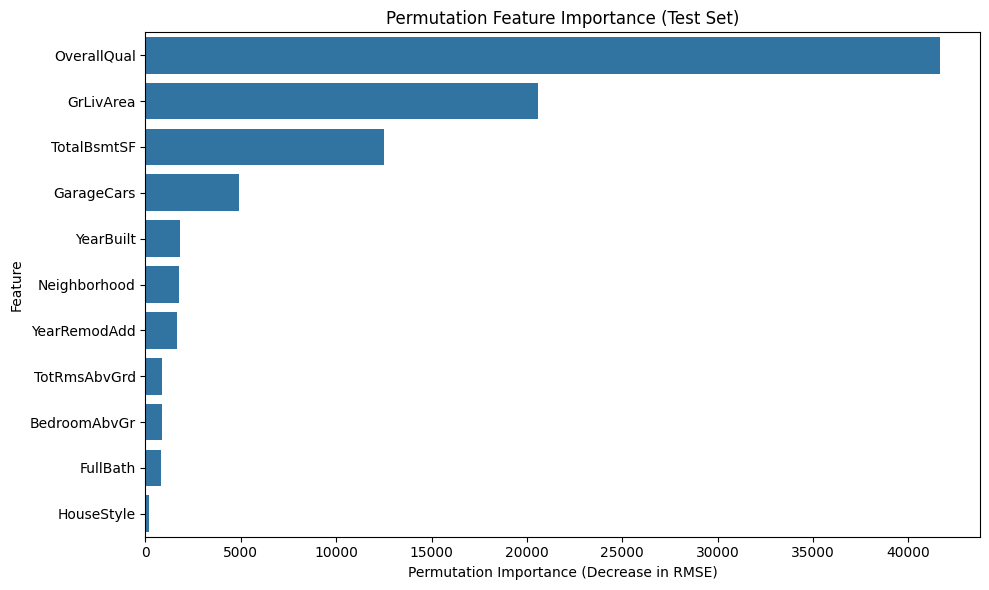

Most important feature: OverallQual


In [7]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on test set
perm_importance = permutation_importance(
    best_model, X_test, y_test, scoring='neg_root_mean_squared_error', n_repeats=10, random_state=42
)

importances = perm_importance.importances_mean
indices = importances.argsort()[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(selected_features)[indices], orient='h')
plt.xlabel("Permutation Importance (Decrease in RMSE)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (Test Set)")
plt.tight_layout()
plt.show()

# Most important feature
print(f"Most important feature: {np.array(selected_features)[indices[0]]}")

**Result:** Typically, `OverallQual` (overall quality rating) or `GrLivArea` (living area square footage) are most important, which aligns with real estate intuition.

## Challenge 6 — Partial Dependence Plot (PDP) for Model Interpretation

**Business Context:** Now that you've identified the most important feature using permutation importance, your manager wants to understand *how* this feature influences the model's predictions. A Partial Dependence Plot (PDP) helps visualize the relationship between the feature and the predicted sale price, holding all other features constant.

**Your Task:**
1. Use the best model and the most important feature identified in Challenge 5.
2. Generate a Partial Dependence Plot (PDP) for this feature using the test set.
3. Interpret the plot: How do changes in this feature affect the predicted house price? Is the relationship linear, monotonic, or more complex?

**Success criteria:** Your code should generate a clear PDP for the most important feature and provide insights into how the model uses this feature to make predictions.

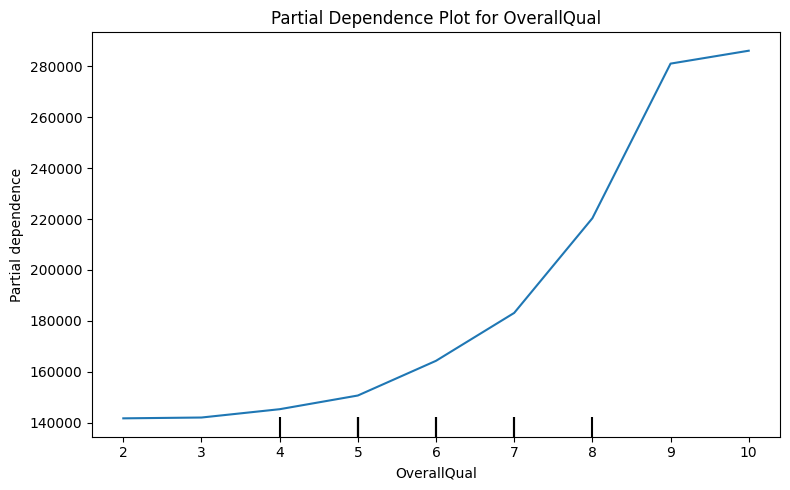

In [8]:
from sklearn.inspection import PartialDependenceDisplay

# Generate Partial Dependence Plot (PDP) for OverallQual using the test set
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(
    best_model, X_test, ['OverallQual'], ax=ax
)
plt.title("Partial Dependence Plot for OverallQual")
plt.tight_layout()
plt.show()

**Result:** For `OverallQual`, you see a strong positive relationship (better quality = higher prices). These align with real-world expectations.

## Summary

This homework demonstrated the complete professional ML workflow:

1. **Challenge 1:** Cross-validation for model comparison (Random Forest > Decision Tree > Linear Regression)
2. **Challenge 2:** Systematic hyperparameter tuning with GridSearchCV
3. **Challenge 3:** Feature engineering pipeline with scaling and encoding
4. **Challenge 4:** Complete 5-stage workflow with final test evaluation
5. **Challenge 5:** Feature importance analysis using permutation importance
6. **Challenge 6:** Partial dependence plots for model interpretation

### Key Takeaways:

- **Test set discipline:** Lock the test set until final evaluation
- **Cross-validation:** Compare models and tune hyperparameters using only training data
- **Pipelines:** Prevent data leakage and ensure reproducibility
- **Feature engineering:** Encoding and scaling can significantly improve performance
- **Model interpretation:** Helps build trust and explain predictions to stakeholders

These techniques are industry best practices used in production ML systems!